In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/Shareddrives/IDS-575 Project/train.csv')
#df_test=pd.read_csv('/content/drive/Shareddrives/IDS-575 Project/test.csv')
#df = pd.concat([df,df_test])
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [ ]:
print (df.isnull().sum())
rows,column=df.shape
print(rows)
print(column)

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

In [ ]:
df = df.dropna(how='any',axis=0) 
rows,column=df.shape
print(rows)
print(column)

225493
41


In [ ]:
#removing columns that are not relevent
df=df.drop(['UniqueID'], axis=1)
df=df.drop(['branch_id'], axis=1)
df=df.drop(['supplier_id'], axis=1)
df=df.drop(['manufacturer_id'], axis=1)
df=df.drop(['Aadhar_flag'], axis=1)
df=df.drop(['PAN_flag'], axis=1)
df=df.drop(['VoterID_flag'], axis=1)
df=df.drop(['Driving_flag'], axis=1)
df=df.drop(['Passport_flag'], axis=1)
df=df.drop(['Current_pincode_ID'], axis=1)
df=df.drop(['Employee_code_ID'], axis=1)
df=df.drop(['State_ID'], axis=1)
df=df.drop(['DisbursalDate'], axis=1) # Not sure if we should drop it
df=df.drop(['MobileNo_Avl_Flag'], axis=1) # Have single value



In [ ]:
#df=df.drop(['DisbursalDate'], axis=1) # Not sure if we should drop it
#df=df.drop(['MobileNo_Avl_Flag'], axis=1) # Have single value
#df_new=df_new.drop(['MobileNo_Avl_Flag'], axis=1) # Have single value

In [ ]:
df.dtypes

disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
Date.of.Birth                           object
Employment.Type                         object
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACCTS                          int64
PRI.ACTIVE.ACCTS                         int64
PRI.OVERDUE.ACCTS                        int64
PRI.CURRENT.BALANCE                      int64
PRI.SANCTIONED.AMOUNT                    int64
PRI.DISBURSED.AMOUNT                     int64
SEC.NO.OF.ACCTS                          int64
SEC.ACTIVE.ACCTS                         int64
SEC.OVERDUE.ACCTS                        int64
SEC.CURRENT.BALANCE                      int64
SEC.SANCTIONED.AMOUNT                    int64
SEC.DISBURSED.AMOUNT                     int64
PRIMARY.INSTAL.AMT                       int64
SEC.INSTAL.AMT                           int64
NEW.ACCTS.IN.

In [ ]:
#Significance testing
#Employment.Type   
from scipy.stats import chi2_contingency
temp= pd.crosstab(df["Employment.Type"], df["loan_default"])
stat, p, dof, expected = chi2_contingency(temp)
print(p)



2.2841351170641894e-43


In [ ]:
#Significance Testing
#disbursed_amount
from scipy.stats import ttest_ind
temp1=df['disbursed_amount'][df['loan_default']==1]
temp2=df['disbursed_amount'][df['loan_default']==0]
stat,p=ttest_ind(temp1,temp2)
print(p)

0.0


In [ ]:
#Significance Testing
#disbursed_amount
from scipy.stats import ttest_ind
temp1=df['PRI.SANCTIONED.AMOUNT'][df['loan_default']==1]
temp2=df['PRI.SANCTIONED.AMOUNT'][df['loan_default']==0]
stat,p=ttest_ind(temp1,temp2)
print(p)

8.637541069326994e-08


In [ ]:
#Changing column of AVERAGE.ACCT.AGE and CREDIT.HISTORY.MONTH from years, months to only months format

def yearmonth_to_month(column):
    year = int(column.split()[0].replace('yrs',''))
    month = int(column.split()[1].replace('mon',''))
    return (year*12)+month
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(yearmonth_to_month)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(yearmonth_to_month)
df.head(20)

,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,01-01-84,Salaried,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,47145,65550,73.23,31-07-85,Self employed,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,23,23,0,1
2,53278,61360,89.63,24-08-85,Self employed,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,57513,66113,88.48,30-12-93,Self employed,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,8,15,1,1
4,52378,60300,88.39,09-12-77,Self employed,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
5,54513,61900,89.66,08-09-90,Self employed,825,A-Very Low Risk,2,0,0,0,0,0,0,0,0,0,0,0,1347,0,0,0,21,24,0,0
6,46349,61500,76.42,01-06-88,Salaried,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,43894,61900,71.89,04-10-89,Salaried,17,Not Scored: Not Enough Info available on the c...,1,1,0,72879,74500,74500,0,0,0,0,0,0,0,0,0,0,2,2,0,0
8,53713,61973,89.56,15-11-91,Self employed,718,D-Very Low Risk,1,1,0,-41,365384,365384,0,0,0,0,0,0,0,0,0,0,56,56,1,0
9,52603,61300,86.95,01-06-68,Salaried,818,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,2608,0,0,0,19,19,0,0


In [ ]:
#Calculating Age using Date of Birth

def dob_to_age(dob):
    if int(dob[-2:]) < 19:
        year = int('20' + dob[-2:])
    else:
        year = int('19' + dob[-2:])    
    return (pd.to_datetime('today').year - year)
df['Age']=df['Date.of.Birth'].apply(dob_to_age)
df.head()

,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Age
0,50578,58400,89.55,01-01-84,Salaried,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37
1,47145,65550,73.23,31-07-85,Self employed,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,23,23,0,1,36
2,53278,61360,89.63,24-08-85,Self employed,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36
3,57513,66113,88.48,30-12-93,Self employed,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,8,15,1,1,28
4,52378,60300,88.39,09-12-77,Self employed,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,44


In [ ]:
#Dropping Date of Birth column
df.drop('Date.of.Birth', axis=1, inplace=True)
df['Age'].describe()

count    225493.000000
mean         37.448009
std           9.666254
min          23.000000
25%          29.000000
50%          36.000000
75%          44.000000
max          67.000000
Name: Age, dtype: float64

225493
   disbursed_amount  asset_cost    ltv  ... loan_default  Age   Age_Group
0             50578       58400  89.55  ...            0   37  Age_31to40
1             47145       65550  73.23  ...            1   36  Age_31to40
2             53278       61360  89.63  ...            0   36  Age_31to40
3             57513       66113  88.48  ...            1   28   Age_0to30
4             52378       60300  88.39  ...            1   44     Age_40+
5             54513       61900  89.66  ...            0   31  Age_31to40
6             46349       61500  76.42  ...            0   33  Age_31to40
7             43894       61900  71.89  ...            0   32  Age_31to40
8             53713       61973  89.56  ...            0   30   Age_0to30
9             52603       61300  86.95  ...            0   53     Age_40+

[10 rows x 28 columns]
Age_31to40    80198
Age_40+       78383
Age_0to30     66912
Name: Age_Group, dtype: int64


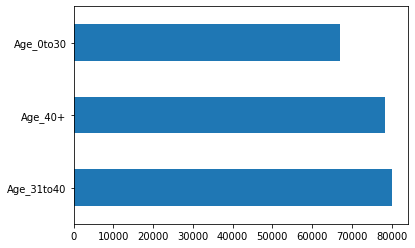

In [ ]:
df = df.reset_index(drop=True)
df['Age_Group'] = "Undecided"
rows,columns=df.shape
print(rows)
i=0
for i in range(0, rows):
  #print(df.iloc[i]['Positive Sentiment'])
  if  df.iloc[i]['Age']>= 0 and df.iloc[i]['Age']<=30:
      #print(df.iloc[i]['Positive Sentiment'])
      #print("Positive")
      df.at[i,'Age_Group']="Age_0to30"
  elif df.iloc[i]['Age']>= 31 and df.iloc[i]['Age']<=40:
    #print("Negative")
    df.at[i,'Age_Group']="Age_31to40"
  else:
    #print("Neutral")
    df.at[i,'Age_Group']="Age_40+"

print(df.head(10))
print(df['Age_Group'].value_counts())
df['Age_Group'].value_counts().plot(kind='barh');

In [ ]:
df = df.rename(columns={'Employment.Type': 'EmploymentType', 'PERFORM_CNS.SCORE.DESCRIPTION': 'PERFORM_CNS_SCORE_DESCRIPTION'})

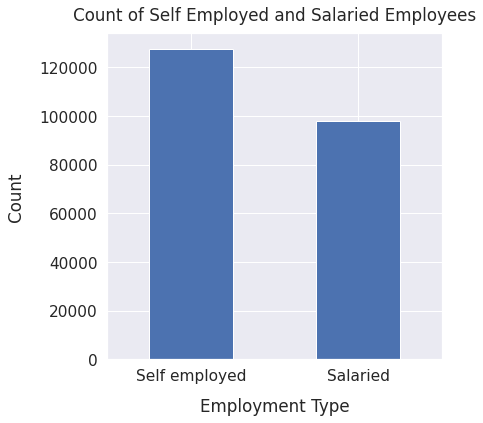

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#df['EmploymentType'].value_counts().plot(kind='bar');
sns.set(font_scale=1.4)
df['EmploymentType'].value_counts().plot(kind='bar', figsize=(6, 6), rot=0)
plt.xlabel("Employment Type", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Count of Self Employed and Salaried Employees", y=1.02);


In [ ]:
print(df['PERFORM_CNS_SCORE_DESCRIPTION'].value_counts())

No Bureau History Available                                111773
C-Very Low Risk                                             15715
A-Very Low Risk                                             13790
D-Very Low Risk                                             11134
B-Very Low Risk                                              9032
M-Very High Risk                                             8632
F-Low Risk                                                   8309
K-High Risk                                                  8107
H-Medium Risk                                                6695
E-Low Risk                                                   5695
I-Medium Risk                                                5440
G-Low Risk                                                   3902
Not Scored: Sufficient History Not Available                 3671
J-High Risk                                                  3667
Not Scored: Not Enough Info available on the customer        3557
Not Scored

 Bureau     111773
Very Low     49671
Low Risk     17906
t Scored     12480
Medium R     12135
High Ris     11774
Very Hig      9754
Name: PERFORM_CNS_SCORE_DESCRIPTION, dtype: int64


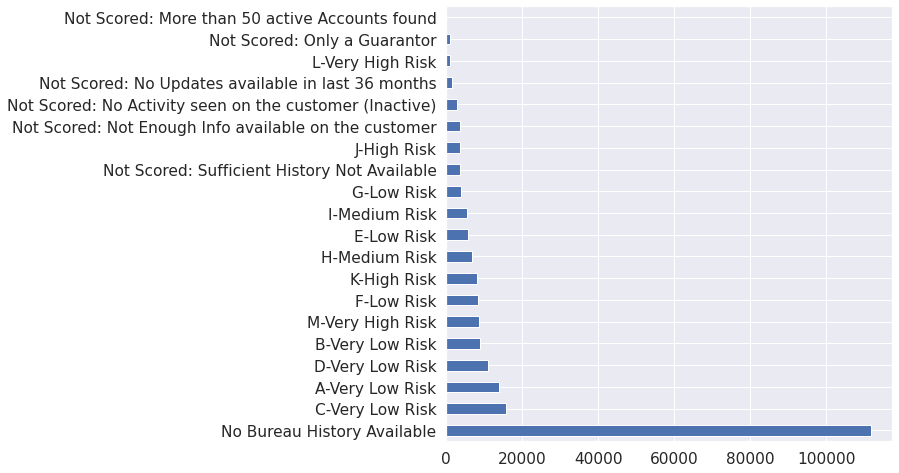

In [ ]:
plt.figure(figsize=(8,8))
print(df['PERFORM_CNS_SCORE_DESCRIPTION'].str[2:10].value_counts())
df['PERFORM_CNS_SCORE_DESCRIPTION'].value_counts().plot(kind='barh');


225493
   disbursed_amount  asset_cost  ...   Age_Group PERFORM_CNS_SCORE_DESCRIPTION_short
0             50578       58400  ...  Age_31to40                             No Info
1             47145       65550  ...  Age_31to40                Medium Risk customer
2             53278       61360  ...  Age_31to40                             No Info
3             57513       66113  ...   Age_0to30                  High Risk customer
4             52378       60300  ...     Age_40+                             No Info
5             54513       61900  ...  Age_31to40                   Low Risk customer
6             46349       61500  ...  Age_31to40                             No Info
7             43894       61900  ...  Age_31to40                             No Info
8             53713       61973  ...   Age_0to30                   Low Risk customer
9             52603       61300  ...     Age_40+                   Low Risk customer

[10 rows x 29 columns]
No Info                 124253
Low

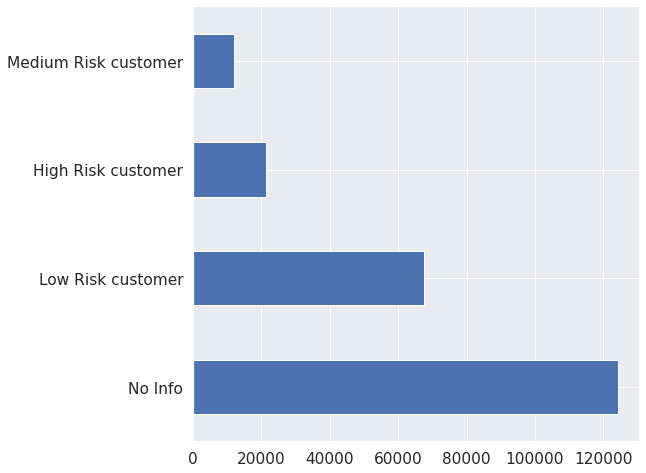

In [ ]:
df['PERFORM_CNS_SCORE_DESCRIPTION']=df['PERFORM_CNS_SCORE_DESCRIPTION'].str[2:10]
df = df.reset_index(drop=True)
df['PERFORM_CNS_SCORE_DESCRIPTION_short'] = "Undecided"
rows,columns=df.shape
print(rows)
i=0
for i in range(0, rows):
  #print(df.iloc[i]['Positive Sentiment'])
  if  df.iloc[i]['PERFORM_CNS_SCORE_DESCRIPTION']== "Very Low" or df.iloc[i]['PERFORM_CNS_SCORE_DESCRIPTION']== "Low Risk":
      #print(df.iloc[i]['Positive Sentiment'])
      #print("Positive")
      df.at[i,'PERFORM_CNS_SCORE_DESCRIPTION_short']="Low Risk customer"
  elif df.iloc[i]['PERFORM_CNS_SCORE_DESCRIPTION']== "Medium R" :
    #print("Negative")
    df.at[i,'PERFORM_CNS_SCORE_DESCRIPTION_short']="Medium Risk customer"
  elif  df.iloc[i]['PERFORM_CNS_SCORE_DESCRIPTION']== "High Ris" or df.iloc[i]['PERFORM_CNS_SCORE_DESCRIPTION']== "Very Hig":
      #print(df.iloc[i]['Positive Sentiment'])
      #print("Positive")
      df.at[i,'PERFORM_CNS_SCORE_DESCRIPTION_short']="High Risk customer"
  else:
    #print("Neutral")
    df.at[i,'PERFORM_CNS_SCORE_DESCRIPTION_short']="No Info"

print(df.head(10))
print(df['PERFORM_CNS_SCORE_DESCRIPTION_short'].value_counts())
plt.figure(figsize=(8,8))
df['PERFORM_CNS_SCORE_DESCRIPTION_short'].value_counts().plot(kind='barh');

In [ ]:
df=df.drop(['Age'], axis=1)
df=df.drop(['PERFORM_CNS_SCORE_DESCRIPTION'], axis=1)

In [ ]:
#one hot encoding for categorical variables
EmpType=pd.get_dummies(df.EmploymentType)
print(EmpType.head())
CNS_Score_Desc=pd.get_dummies(df.PERFORM_CNS_SCORE_DESCRIPTION_short)
print(CNS_Score_Desc.head())
Age_Group=pd.get_dummies(df.Age_Group)
print(CNS_Score_Desc.head())
df_new=pd.concat([df, EmpType], axis=1)
df_new=pd.concat([df_new, CNS_Score_Desc], axis=1)
df_new=pd.concat([df_new, Age_Group], axis=1)
print(df_new.head())
#Dropping the categorical variables
df_new = df_new.drop('EmploymentType', 1)
df_new = df_new.drop('PERFORM_CNS_SCORE_DESCRIPTION_short', 1)
df_new = df_new.drop('Age_Group', 1)
#Droping as part of One-hot encoding
df_new = df_new.drop('Self employed', 1)
df_new = df_new.drop('No Info', 1)
df_new = df_new.drop('Age_40+', 1)

print(df_new.head())

   Salaried  Self employed
0         1              0
1         0              1
2         0              1
3         0              1
4         0              1
   High Risk customer  Low Risk customer  Medium Risk customer  No Info
0                   0                  0                     0        1
1                   0                  0                     1        0
2                   0                  0                     0        1
3                   1                  0                     0        0
4                   0                  0                     0        1
   High Risk customer  Low Risk customer  Medium Risk customer  No Info
0                   0                  0                     0        1
1                   0                  0                     1        0
2                   0                  0                     0        1
3                   1                  0                     0        0
4                   0                  0      

In [ ]:
#Making sure that only continous variables are left
#df_new=df
print(df_new.head())
df_new.dtypes

   disbursed_amount  asset_cost  ...  Age_0to30  Age_31to40
0             50578       58400  ...          0           1
1             47145       65550  ...          0           1
2             53278       61360  ...          0           1
3             57513       66113  ...          1           0
4             52378       60300  ...          0           0

[5 rows x 30 columns]


disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
PERFORM_CNS.SCORE                        int64
PRI.NO.OF.ACCTS                          int64
PRI.ACTIVE.ACCTS                         int64
PRI.OVERDUE.ACCTS                        int64
PRI.CURRENT.BALANCE                      int64
PRI.SANCTIONED.AMOUNT                    int64
PRI.DISBURSED.AMOUNT                     int64
SEC.NO.OF.ACCTS                          int64
SEC.ACTIVE.ACCTS                         int64
SEC.OVERDUE.ACCTS                        int64
SEC.CURRENT.BALANCE                      int64
SEC.SANCTIONED.AMOUNT                    int64
SEC.DISBURSED.AMOUNT                     int64
PRIMARY.INSTAL.AMT                       int64
SEC.INSTAL.AMT                           int64
NEW.ACCTS.IN.LAST.SIX.MONTHS             int64
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS      int64
AVERAGE.ACCT.AGE                         int64
CREDIT.HISTOR

In [ ]:
#removing Highly correlated columns
corr = df_new.corr()

corr.style.background_gradient(cmap='coolwarm')




,disbursed_amount,asset_cost,ltv,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Salaried,High Risk customer,Low Risk customer,Medium Risk customer,Age_0to30,Age_31to40
disbursed_amount,1.000000,0.746037,0.386100,0.014416,0.036134,0.042334,0.020517,0.016738,0.006778,0.006891,-0.014650,-0.014029,-0.007385,-0.004183,-0.005198,-0.005046,0.001982,-0.005591,0.038143,0.021570,0.004698,0.014641,0.039704,0.079286,0.020152,0.024343,0.002627,0.014487,0.059556,-0.023538
asset_cost,0.746037,1.000000,-0.301058,-0.044755,-0.026137,-0.019299,-0.013705,-0.003096,-0.000442,-0.000499,-0.022600,-0.020414,-0.013616,-0.008704,-0.010786,-0.010605,-0.005412,-0.005861,-0.020691,-0.006612,-0.014789,-0.022325,-0.016940,0.015620,-0.058407,-0.008809,-0.039259,-0.005300,0.116272,-0.026788
ltv,0.386100,-0.301058,1.000000,0.084149,0.086871,0.087405,0.051155,0.026062,0.009494,0.009727,0.013161,0.010749,0.010196,0.007126,0.008735,0.008675,0.008008,0.000593,0.084097,0.041485,0.028844,0.052877,0.085804,0.097996,0.107451,0.050805,0.057869,0.029641,-0.075247,0.002836
PERFORM_CNS.SCORE,0.014416,-0.044755,0.084149,1.000000,0.422015,0.469250,0.105011,0.146359,0.077980,0.077323,0.056463,0.049975,0.035088,0.020052,0.024258,0.023859,0.070715,0.015726,0.344305,0.163027,0.472361,0.469937,0.151097,-0.059730,0.044901,0.099584,0.862897,0.218479,-0.178534,0.055730
PRI.NO.OF.ACCTS,0.036134,-0.026137,0.086871,0.422015,1.000000,0.752853,0.351359,0.303632,0.158134,0.157640,0.057152,0.046911,0.030700,0.020878,0.024839,0.024521,0.271156,0.023784,0.535447,0.314398,0.233110,0.465023,0.179966,-0.035954,-0.006307,0.282568,0.286676,0.126941,-0.176021,0.033905
PRI.ACTIVE.ACCTS,0.042334,-0.019299,0.087405,0.469250,0.752853,1.000000,0.380977,0.417225,0.219136,0.218400,0.062813,0.055367,0.037482,0.021892,0.026666,0.026204,0.192890,0.021321,0.701388,0.382647,0.293489,0.504259,0.194702,-0.042311,0.008473,0.315485,0.319177,0.148408,-0.160072,0.048948
PRI.OVERDUE.ACCTS,0.020517,-0.013705,0.051155,0.105011,0.351359,0.380977,1.000000,0.226863,0.115703,0.117355,0.046067,0.040690,0.041250,0.012634,0.017211,0.016872,0.103598,0.009413,0.108118,0.471278,0.312755,0.425520,0.063069,0.040926,-0.023159,0.662673,-0.131190,0.075487,-0.122815,-0.000630
PRI.CURRENT.BALANCE,0.016738,-0.003096,0.026062,0.146359,0.303632,0.417225,0.226863,1.000000,0.462723,0.468286,0.025494,0.018071,0.015295,0.019426,0.021223,0.021197,0.150539,0.006872,0.198091,0.244715,0.145920,0.247283,0.023693,-0.027517,-0.020649,0.152120,0.073632,0.057025,-0.076699,0.002528
PRI.SANCTIONED.AMOUNT,0.006778,-0.000442,0.009494,0.077980,0.158134,0.219136,0.115703,0.462723,1.000000,0.998750,0.013134,0.009581,0.007949,0.010720,0.011821,0.011805,0.071898,0.003900,0.094297,0.121626,0.082655,0.133319,0.010571,-0.011273,-0.012256,0.075737,0.041433,0.028888,-0.040834,-0.000362
PRI.DISBURSED.AMOUNT,0.006891,-0.000499,0.009727,0.077323,0.157640,0.218400,0.117355,0.468286,0.998750,1.000000,0.012917,0.009369,0.007854,0.010653,0.011734,0.011720,0.072140,0.003822,0.093905,0.122269,0.082464,0.132742,0.010759,-0.011118,-0.012506,0.076594,0.040540,0.028884,-0.040779,-0.000617


In [ ]:
df_new = df_new.drop('asset_cost', 1)  # complete correlation with disbursed_amount 
df_new = df_new.drop('PERFORM_CNS.SCORE', 1)  # complete correlation with ltv
df_new = df_new.drop('PRI.ACTIVE.ACCTS', 1)  # complete correlation with PRI.NO.OF.ACCTS
df_new = df_new.drop('PRI.DISBURSED.AMOUNT', 1)  # complete correlation with PRI.SANCTIONED.AMOUNT 
df_new = df_new.drop('SEC.ACTIVE.ACCTS', 1)  #  correlation with SEC.NO.OF.ACCTS
df_new = df_new.drop('SEC.CURRENT.BALANCE', 1)  #  correlation with SEC.SANCTIONED.AMOUNT 
df_new = df_new.drop('SEC.DISBURSED.AMOUNT', 1)  #  correlation with SEC.SANCTIONED.AMOUNT 
df_new = df_new.drop('AVERAGE.ACCT.AGE', 1)  #  correlation with CREDIT.HISTORY.LENGTH 
#df_new = df_new.drop('No Bureau History Available', 1)  #  correlation with PERFORM_CNS.SCORE

In [ ]:
#removing Highly correlated columns
corr = df_new.corr()

corr.style.background_gradient(cmap='coolwarm')

,disbursed_amount,ltv,PRI.NO.OF.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,SEC.NO.OF.ACCTS,SEC.OVERDUE.ACCTS,SEC.SANCTIONED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Salaried,High Risk customer,Low Risk customer,Medium Risk customer,Age_0to30,Age_31to40
disbursed_amount,1.000000,0.386100,0.036134,0.020517,0.016738,0.006778,-0.014650,-0.007385,-0.005198,0.001982,-0.005591,0.038143,0.021570,0.014641,0.039704,0.079286,0.020152,0.024343,0.002627,0.014487,0.059556,-0.023538
ltv,0.386100,1.000000,0.086871,0.051155,0.026062,0.009494,0.013161,0.010196,0.008735,0.008008,0.000593,0.084097,0.041485,0.052877,0.085804,0.097996,0.107451,0.050805,0.057869,0.029641,-0.075247,0.002836
PRI.NO.OF.ACCTS,0.036134,0.086871,1.000000,0.351359,0.303632,0.158134,0.057152,0.030700,0.024839,0.271156,0.023784,0.535447,0.314398,0.465023,0.179966,-0.035954,-0.006307,0.282568,0.286676,0.126941,-0.176021,0.033905
PRI.OVERDUE.ACCTS,0.020517,0.051155,0.351359,1.000000,0.226863,0.115703,0.046067,0.041250,0.017211,0.103598,0.009413,0.108118,0.471278,0.425520,0.063069,0.040926,-0.023159,0.662673,-0.131190,0.075487,-0.122815,-0.000630
PRI.CURRENT.BALANCE,0.016738,0.026062,0.303632,0.226863,1.000000,0.462723,0.025494,0.015295,0.021223,0.150539,0.006872,0.198091,0.244715,0.247283,0.023693,-0.027517,-0.020649,0.152120,0.073632,0.057025,-0.076699,0.002528
PRI.SANCTIONED.AMOUNT,0.006778,0.009494,0.158134,0.115703,0.462723,1.000000,0.013134,0.007949,0.011821,0.071898,0.003900,0.094297,0.121626,0.133319,0.010571,-0.011273,-0.012256,0.075737,0.041433,0.028888,-0.040834,-0.000362
SEC.NO.OF.ACCTS,-0.014650,0.013161,0.057152,0.046067,0.025494,0.013134,1.000000,0.511862,0.359727,0.010326,0.233017,0.120428,0.100161,0.150603,0.004998,-0.008494,0.004093,0.046403,0.035491,0.015379,-0.020530,0.001395
SEC.OVERDUE.ACCTS,-0.007385,0.010196,0.030700,0.041250,0.015295,0.007949,0.511862,1.000000,0.235092,0.002244,0.075873,0.057372,0.109375,0.123707,0.004634,-0.001482,0.000128,0.036890,0.020733,0.007817,-0.012844,0.001453
SEC.SANCTIONED.AMOUNT,-0.005198,0.008735,0.024839,0.017211,0.021223,0.011821,0.359727,0.235092,1.000000,0.011631,0.113316,0.056008,0.055003,0.070622,0.002626,-0.006384,0.001869,0.015519,0.015450,0.008798,-0.009327,-0.001789
PRIMARY.INSTAL.AMT,0.001982,0.008008,0.271156,0.103598,0.150539,0.071898,0.010326,0.002244,0.011631,1.000000,0.011182,0.125791,0.089916,0.103022,0.008697,-0.010386,-0.013383,0.074701,0.033978,0.036044,-0.042497,-0.006884


In [ ]:
## Typecast of dependent variable (loan default) to Categorical column in pandas
df_new.head()
print(df_new.shape)

#df_new['loan_default'] = pd.Categorical(df_new.loan_default)
df_new.dtypes


(225493, 22)


disbursed_amount                         int64
ltv                                    float64
PRI.NO.OF.ACCTS                          int64
PRI.OVERDUE.ACCTS                        int64
PRI.CURRENT.BALANCE                      int64
PRI.SANCTIONED.AMOUNT                    int64
SEC.NO.OF.ACCTS                          int64
SEC.OVERDUE.ACCTS                        int64
SEC.SANCTIONED.AMOUNT                    int64
PRIMARY.INSTAL.AMT                       int64
SEC.INSTAL.AMT                           int64
NEW.ACCTS.IN.LAST.SIX.MONTHS             int64
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS      int64
CREDIT.HISTORY.LENGTH                    int64
NO.OF_INQUIRIES                          int64
loan_default                             int64
Salaried                                 uint8
High Risk customer                       uint8
Low Risk customer                        uint8
Medium Risk customer                     uint8
Age_0to30                                uint8
Age_31to40   

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


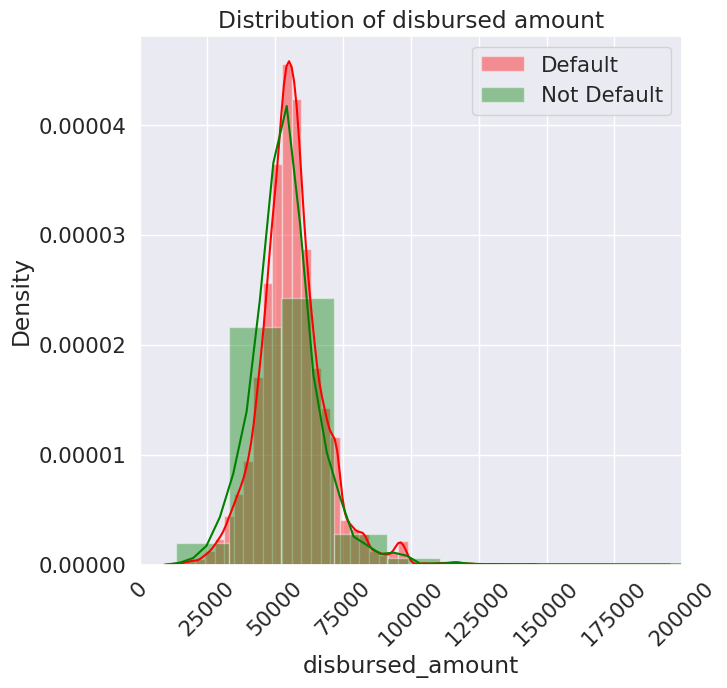

In [ ]:

plt.subplots(figsize=(7,7), dpi=100)
g=sns.distplot( df.loc[df.loan_default==1, "disbursed_amount"] , color="red", label="Default")
g=sns.distplot( df.loc[df.loan_default==0, "disbursed_amount"] , color="green", label="Not Default")
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation = 45)
plt.title('Distribution of disbursed amount')
g.set(xlim=(0, 200000))

plt.legend();

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f883d6ca3d0>]],
      dtype=object)

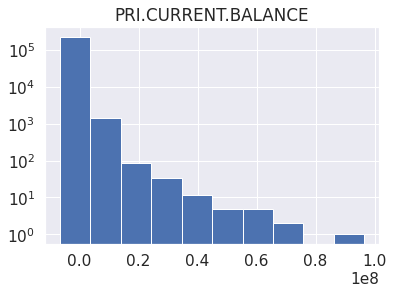

In [ ]:
df.hist(column='PRI.CURRENT.BALANCE',log=True)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f883d79e3d0>]],
      dtype=object)

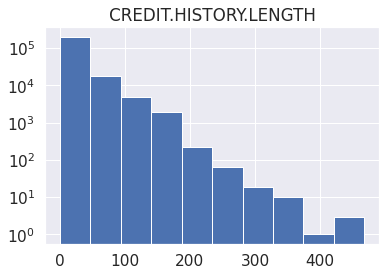

In [ ]:
df.hist(column='CREDIT.HISTORY.LENGTH',log=True)

In [ ]:
df['PRI.CURRENT.BALANCE'].describe()

count    2.254930e+05
mean     1.684813e+05
std      9.516692e+05
min     -6.678296e+06
25%      0.000000e+00
50%      0.000000e+00
75%      3.630000e+04
max      9.652492e+07
Name: PRI.CURRENT.BALANCE, dtype: float64

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import *
import sklearn as sk
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
import sklearn.metrics
from sklearn.dummy import DummyClassifier
log_model = LogisticRegression(solver='lbfgs', max_iter=1000000)
#applying Logistic regression
#df_new=df_new.head(int(len(df_new)/6))
X = df_new
X = X.drop('loan_default', 1)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
y = df_new['loan_default']

In [ ]:
# check the distribution
print(df_new['loan_default'].value_counts())
print(df_new['loan_default'].value_counts()/df_new.shape[0])
X_train,X_test,y_train,y_test = train_test_split(X_std,y,test_size=0.20,random_state=0)


0    176526
1     48967
Name: loan_default, dtype: int64
0    0.782845
1    0.217155
Name: loan_default, dtype: float64


In [ ]:
#weight_for_0 = (1 / neg) * (total / 2.0)= 0.63
#weight_for_1 = (1 / pos) * (total / 2.0)=2.3
w = { 0:1, 1:3.2}

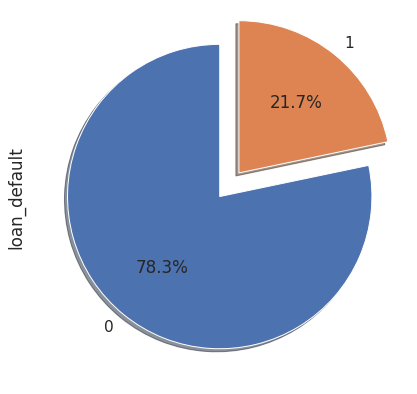

In [ ]:
plt.figure(figsize=(8,7))
df_new['loan_default'].value_counts().plot(kind='pie',autopct='%1.1f%%',startangle=90, shadow=True, explode=[0,0.2]);


In [ ]:
# define class weights
#w = { 0:1, 0.63:2.3}
# define model
#lm = LogisticRegression(random_state=0, class_weight=w)
#lm = LogisticRegression(random_state=0, class_weight='balanced')
#lm.fit(X_train,y_train)
#y_pred= lm.predict(X_test) 
#confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
#sn.heatmap(confusion_matrix, annot=True)
#print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
#plt.show()

Accuracy:  0.7805716313000288


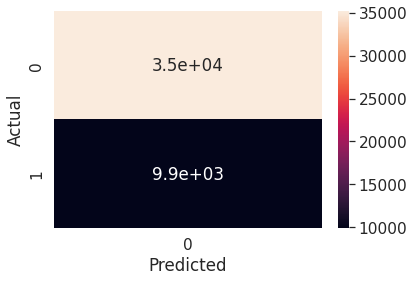

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


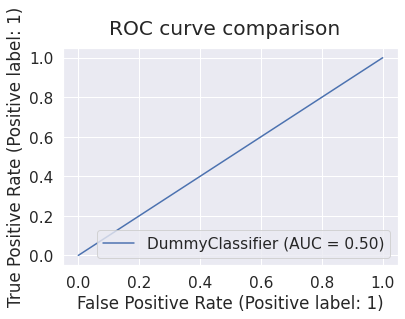

In [ ]:
# define class weights
#w = { 0:1, 1:3.2}
# define model
#lm = LogisticRegression(random_state=0, class_weight=w)
dc = DummyClassifier(strategy="most_frequent")
dc.fit(X_train,y_train)
y_pred_dc= dc.predict(X_test) 
confusion_matrix = pd.crosstab(y_test, y_pred_dc, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_dc))
plt.show()
fig=sklearn.metrics.plot_roc_curve(dc, X_test, y_test) 
fig.figure_.suptitle("ROC curve comparison")
plt.show()

In [ ]:
pip install parfit

  Created wheel for parfit: filename=parfit-0.220-py3-none-any.whl size=8659 sha256=8f6dca94e51761ef7115dd8385931581be4173e26021e5f9fcf5a1d315645fe2
  Stored in directory: /root/.cache/pip/wheels/9a/3b/19/64addee68f796a7e7108c2658a8765d600753bc728e7beb55e
Successfully built parfit


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    5.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished


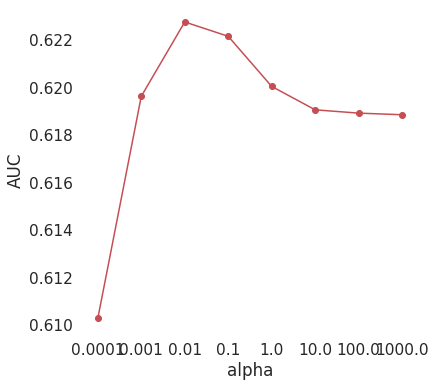

SGDClassifier(alpha=0.01, class_weight='balanced', loss='log', max_iter=1000000,
              n_jobs=-1, penalty='L2') 0.6227666949409099


In [ ]:

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['L2'],
    'class_weight': ['balanced'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,X_train, y_train, X_test, y_test,  metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

Accuracy:  0.6298809286236945


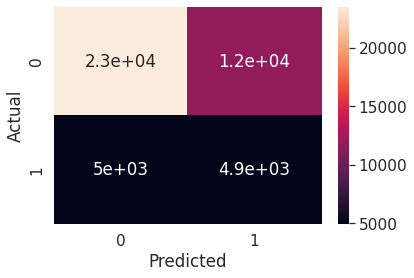

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


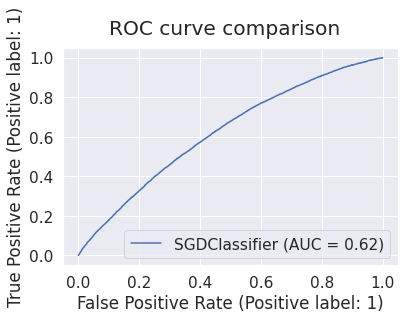

In [ ]:
# define class weights
#w = { 0:1, 1:3.2}
# define model
#lm = LogisticRegression(random_state=0, class_weight=w)
lm = sk.linear_model.SGDClassifier(random_state=0, class_weight=w,loss='log',max_iter=1000000,alpha=0.01,)
lm.fit(X_train,y_train)
y_pred_lr= lm.predict(X_test) 
confusion_matrix = pd.crosstab(y_test, y_pred_lr, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_lr))
plt.show()
fig=sklearn.metrics.plot_roc_curve(lm, X_test, y_test) 
fig.figure_.suptitle("ROC curve comparison")
plt.show()

In [ ]:

print(lm.coef_)

[[ 0.1263724   0.2323916  -0.05325615  0.05983852 -0.10193296  0.09152197
  -0.01319947  0.01863726 -0.00410425  0.00181304 -0.0051924  -0.05577905
   0.05643526 -0.13296515  0.12070952 -0.09305396  0.11297248 -0.11400695
   0.06675426  0.09125699  0.03138644]]


In [ ]:
# check the distribution
from imblearn.over_sampling import SMOTE
print("label ditribution before SMOTE")
print(y_train.value_counts())
smt=SMOTE()
X_train_sm,y_train_sm=smt.fit_resample(X_train,y_train)
print("label ditribution after SMOTE")
print(y_train_sm.value_counts())



label ditribution before SMOTE
0    141323
1     39071
Name: loan_default, dtype: int64
label ditribution after SMOTE
1    141323
0    141323
Name: loan_default, dtype: int64


In [ ]:
X__test_valid,X__test_test,y_test_valid,y_test_test = train_test_split(X_test,y_test,test_size=0.50,random_state=0)

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
#a = []
#K_Values = []
#KNN_Score = []
#KNN_ROC = []
#for i in range(0,211):
#    a.append(0)
#    K_Values.append(0)
#    KNN_Score.append(0)
#    KNN_ROC.append(0)


#print(K_Values)
#print(KNN_ROC)
#print(KNN_ROC)


#for K in range(0,211):    
#     knn = KNeighborsClassifier(n_neighbors = K*2+2, weights='distance')
#    knn.fit(X_train_sm,y_train_sm)
#    pred=knn.predict(X__test_valid)
#    K_Values[K]=K*2+2
#   KNN_Score[K]=metrics.accuracy_score(y_test_valid, pred)
#    KNN_ROC[K]=sklearn.metrics.roc_auc_score(y_test_valid, pred)
#    print("for K= "+str(K_Values[K]))
#    print(K_Values)
#    print("Accuracy= ")
#    print(KNN_Score)
#    print("ROC= ")
#    print(KNN_ROC)      
#    print("\n")

In [ ]:
results_KNN=pd.read_csv('/content/drive/Shareddrives/IDS-575 Project/results_v3.csv')
print(results_KNN.head())
print(results_KNN.shape)
print (results_KNN.isnull().sum())
results_KNN.columns = results_KNN.columns.str.replace(' ', '')
results_KNN['Accuracy'].describe()

    K-values    Accuracy       ROC 
0          20    0.557036  0.557036
1          40    0.567492  0.567492
2          60    0.574088  0.574088
3          80    0.578334  0.578334
4         100    0.579844  0.579844
(61, 3)
 K-values     0
 Accuracy     0
 ROC          0
dtype: int64


count    61.000000
mean      0.592479
std       0.007705
min       0.557036
25%       0.591027
50%       0.595386
75%       0.597146
max       0.598486
Name: Accuracy, dtype: float64

In [ ]:

K_Values = []
KNN_Score = []
KNN_ROC = []
for i in range(0,61):
    K_Values.append(0)
    KNN_Score.append(0)
    KNN_ROC.append(0)
rows,columns=df.shape
for i in range(0, 61):
  K_Values[i]=results_KNN.iloc[i]["K-values"]
  KNN_Score[i]=results_KNN.iloc[i]['Accuracy']
  KNN_ROC[i]=results_KNN.iloc[i]['ROC']

print("for K= ")
print(K_Values)
print("Accuracy= ")
print(KNN_Score)
print("ROC= ")
print(KNN_ROC)      
print("\n")



for K= 
[20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0, 180.0, 200.0, 220.0, 240.0, 260.0, 280.0, 300.0, 320.0, 340.0, 360.0, 380.0, 400.0, 420.0, 440.0, 460.0, 480.0, 500.0, 520.0, 540.0, 560.0, 580.0, 600.0, 620.0, 640.0, 660.0, 680.0, 700.0, 720.0, 740.0, 760.0, 780.0, 800.0, 820.0, 840.0, 860.0, 880.0, 900.0, 920.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0, 4000.0, 4500.0, 5000.0, 5500.0, 6000.0, 6500.0, 7000.0, 7500.0, 8000.0]
Accuracy= 
[0.557036465, 0.567492394, 0.57408837, 0.578334317, 0.57984424, 0.581819627, 0.5845556510000001, 0.586269924, 0.587654966, 0.589732528, 0.590595341, 0.590197993, 0.591344626, 0.592059852, 0.593547069, 0.594171473, 0.5946709960000001, 0.594977521, 0.595386222, 0.5961355070000001, 0.596112801, 0.596192271, 0.5967145, 0.59720267, 0.597055084, 0.596930203, 0.59748649, 0.597191317, 0.597168612, 0.5971459060000001, 0.596952909, 0.597134553, 0.59728214, 0.59691885, 0.596896145, 0.59691885, 0.59691885, 0.597043731, 0.597270787, 0.59756596, 0.59

Text(0.5, 1.0, 'KNN: K-values vs AUC')

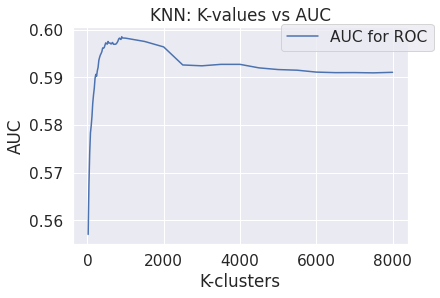

In [ ]:
#plotting part K-values vs AUC
import matplotlib.pyplot as plt
fig, errorplots = plt.subplots()
errorplots.plot(K_Values,KNN_ROC, label='AUC for ROC') 
errorplots.set_ylabel('AUC')
errorplots.set_xlabel('K-clusters')
errorplots.legend(bbox_to_anchor=(1.1, 1.05))
errorplots.set_title('KNN: K-values vs AUC')

Accuracy:  0.5580931263858093


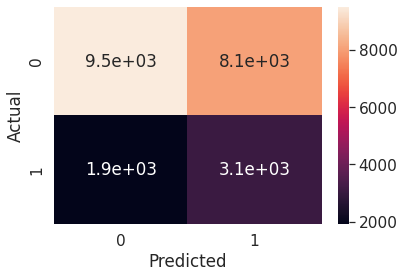

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


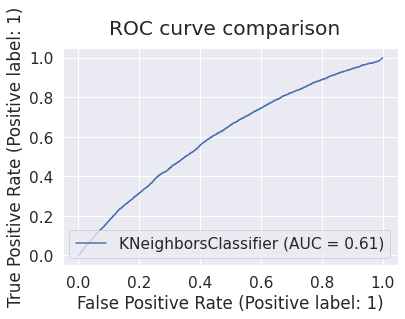

In [ ]:
  
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 180, weights='distance')
knn=knn.fit(X_train_sm,y_train_sm)
pred_knn=knn.predict(X__test_test)

confusion_matrix = pd.crosstab(y_test_test, pred_knn, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test_test, pred_knn))
plt.show()
fig=sklearn.metrics.plot_roc_curve(knn, X__test_test, y_test_test) 
fig.figure_.suptitle("ROC curve comparison")
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.wa

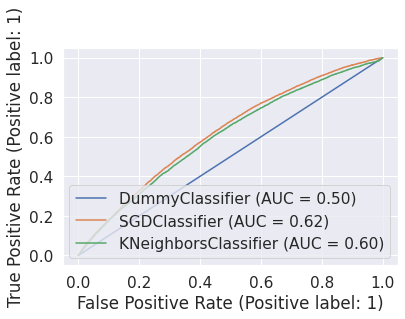

In [ ]:

classifiers = [ dc, lm , knn]
ax = plt.gca()
for i in classifiers:
    sklearn.metrics.plot_roc_curve(i, X_test, y_test, ax=ax)

In [ ]:
#C_value=[1/8,1/2,1,2,4,8,16,32,64]
#Accuracy_SVM=[0,0,0,0,0,0,0,0,0]
#ROC_SVM=[0,0,0,0,0,0,0,0,0]



#for i in range(0,len(C_value)):
#  model = SVC(kernel='linear',C =C_value[i], class_weight='balanced')
#  model = model.fit(X_train,y_train)
#  pred_SVM=model.predict(X__test_valid)
#  Accuracy_SVM[i]=metrics.accuracy_score(y_test_valid, pred_SVM)
#  ROC_SVM[i]=sklearn.metrics.roc_auc_score(y_test_valid, pred_SVM)
#  print("for C= ")
#  print(C_value)
#  print("Accuracy= ")
#  print(Accuracy_SVM)
#  print("ROC= ")
#  print(ROC_SVM)      
#  print("\n")

In [ ]:
results_SVM=pd.read_csv('/content/drive/Shareddrives/IDS-575 Project/results_SVM.csv')
print(results_SVM.head())
print(results_SVM.shape)
print (results_SVM.isnull().sum())
results_SVM.columns = results_SVM.columns.str.replace(' ', '')
results_SVM['C_values'].describe()

   C_values   Accuracy       ROC 
0     0.125    0.508690  0.579230
1     0.500    0.508846  0.579328
2     1.000    0.509090  0.579357
3     2.000    0.509446  0.579378
4     4.000    0.512601  0.579400
(9, 3)
C_values      0
 Accuracy     0
 ROC          0
dtype: int64


count     9.000000
mean     14.180556
std      21.364317
min       0.125000
25%       1.000000
50%       4.000000
75%      16.000000
max      64.000000
Name: C_values, dtype: float64

In [ ]:

C_values = []
SVM_Score = []
SVM_ROC = []
for i in range(0,9):
    C_values.append(0)
    SVM_Score.append(0)
    SVM_ROC.append(0)
rows,columns=df.shape
for i in range(0, 9):
  C_values[i]=results_SVM.iloc[i]["C_values"]
  SVM_Score[i]=results_SVM.iloc[i]['Accuracy']
  SVM_ROC[i]=results_SVM.iloc[i]['ROC']

print("for C= ")
print(C_values)
print("Accuracy= ")
print(SVM_Score)
print("ROC= ")
print(SVM_ROC)      
print("\n")


for C= 
[0.125, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]
Accuracy= 
[0.50869, 0.508846, 0.5090899999999999, 0.509446, 0.512601, 0.51569, 0.5198229999999999, 0.5193369999999999, 0.519312]
ROC= 
[0.57923, 0.579328, 0.579357, 0.579378, 0.5794, 0.57943, 0.579462, 0.5794239999999999, 0.579421]




Text(0.5, 1.0, 'SVM: log C-values vs AUC')

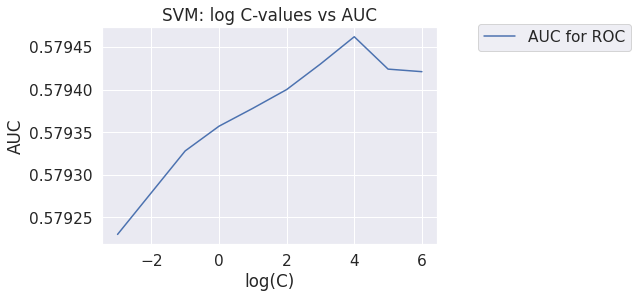

In [ ]:
#plotting part C-values vs AUC
import matplotlib.pyplot as plt
Log_C_values = np.log2(C_values)
fig, errorplots = plt.subplots()
errorplots.plot(Log_C_values,SVM_ROC, label='AUC for ROC') 
errorplots.set_ylabel('AUC')
errorplots.set_xlabel('log(C)')
errorplots.legend(bbox_to_anchor=(1.1, 1.05))
errorplots.set_title('SVM: log C-values vs AUC')

for C= 
[0.125]
Accuracy= 
[0.5125055432372505]
ROC= 
[0.586832175834918]


Accuracy:  0.5125055432372505


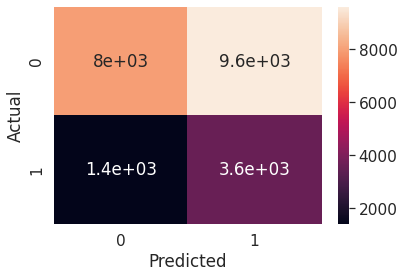

In [ ]:
#C_value=[1/8,1/2,1,2,4,8,16,64,128]
#Accuracy_SVM=[0,0,0,0,0,0,0,0,0]
#ROC_SVM=[0,0,0,0,0,0,0,0,0]

C_value=[16]
Accuracy_SVM=[0]
ROC_SVM=[0]

for i in range(0,len(C_value)):
  model = SVC(kernel='linear',C =C_value[i], class_weight='balanced')
  model = model.fit(X_train,y_train)
  pred_SVM=model.predict(X__test_test)
  Accuracy_SVM[i]=metrics.accuracy_score(y_test_test, pred_SVM)
  ROC_SVM[i]=sklearn.metrics.roc_auc_score(y_test_test, pred_SVM)
  print("for C= ")
  print(C_value)
  print("Accuracy= ")
  print(Accuracy_SVM)
  print("ROC= ")
  print(ROC_SVM)      
  print("\n")
  confusion_matrix = pd.crosstab(y_test_test, pred_SVM, rownames=['Actual'], colnames=['Predicted'])
  sn.heatmap(confusion_matrix, annot=True)
  print('Accuracy: ',metrics.accuracy_score(y_test_test, pred_SVM))
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.wa

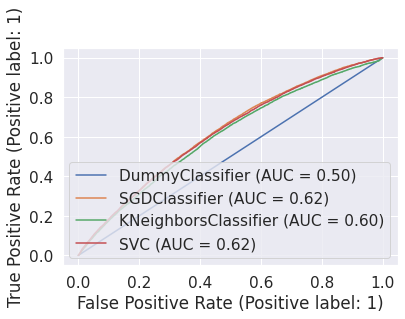

In [ ]:

classifiers = [ dc, lm , knn,model]
ax = plt.gca()
for i in classifiers:
    sklearn.metrics.plot_roc_curve(i, X_test, y_test, ax=ax)

In [ ]:
from sklearn.metrics import classification_report
print("\n SVM \n")
print(classification_report(y_test_test,pred_SVM))
print("\n KNN \n")
print(classification_report(y_test_test,pred_knn))
print("\n LR \n")
print(classification_report(y_test,y_pred_lr))
print("\n DC \n")
print(classification_report(y_test,y_pred_dc))


 SVM 

              precision    recall  f1-score   support

           0       0.85      0.45      0.59     17562
           1       0.27      0.72      0.40      4988

    accuracy                           0.51     22550
   macro avg       0.56      0.59      0.49     22550
weighted avg       0.72      0.51      0.55     22550


 KNN 

              precision    recall  f1-score   support

           0       0.83      0.54      0.66     17562
           1       0.28      0.62      0.38      4988

    accuracy                           0.56     22550
   macro avg       0.55      0.58      0.52     22550
weighted avg       0.71      0.56      0.60     22550


 LR 

              precision    recall  f1-score   support

           0       0.83      0.67      0.74     35203
           1       0.30      0.50      0.37      9896

    accuracy                           0.63     45099
   macro avg       0.56      0.58      0.55     45099
weighted avg       0.71      0.63      0.66     450